# Predicting Future Ocean Acidification

#### Importing Data and Packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
import matplotlib.dates as mdates
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.stats.stattools import durbin_watson

In [3]:
# reading CSV
df1 = pd.read_csv(r"C:\Users\datre\OneDrive\Documents\Graduate School\Spring '21\Project\2013_2014.csv")

In [4]:
# Looking at data types and numbers
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Mooring Name               4123 non-null   object 
 1   Latitude                   4123 non-null   float64
 2   Longitude                  4123 non-null   float64
 3   Date                       4123 non-null   object 
 4   Time                       4123 non-null   object 
 5   xCO2 SW (wet) (umol/mol)   4123 non-null   float64
 6   CO2 SW QF                  4123 non-null   int64  
 7   H2O SW (mmol/mol)          4123 non-null   float64
 8   xCO2 Air (wet) (umol/mol)  4123 non-null   float64
 9   CO2 Air QF                 4123 non-null   int64  
 10  H2O Air (mmol/mol)         4123 non-null   float64
 11  Licor Atm Pressure (hPa)   4123 non-null   float64
 12  Licor Temp (C)             4123 non-null   float64
 13  MAPCO2 %O2                 4123 non-null   float

In [4]:
# Removing features where every instance has the same thing
# Data was taken from the same mooring, with the same latitude and longitude
del df1["Mooring Name"]
del df1["Latitude"]
del df1["Longitude"]

In [5]:
# creating one datetime column with seperate date and time columns
df1["Datetime"] = pd.to_datetime(df1["Date"] + " " + df1["Time"])

In [6]:
# setting index as datetime column
df1 = df1.set_index("Datetime")

In [7]:
# grouping data by day versus by hour
df1 = df1.groupby(pd.Grouper(freq='1D')).mean()
df1.head(3)

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),CO2 SW QF,H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),CO2 Air QF,H2O Air (mmol/mol),Licor Atm Pressure (hPa),Licor Temp (C),...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,pH (Total Scale),pH QF
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-04-24,7.464,151.898,397.9250,2.0,9.56000,394.375,2.0,8.70500,1006.9750,30.6750,...,401.7750,397.875,382.6750,378.9500,3.7000,383.8250,380.100,3.7250,8.03300,2.0
2013-04-25,7.464,151.898,396.5750,2.0,10.11625,393.775,2.0,9.10875,1006.8125,30.9125,...,400.6250,397.400,381.4250,378.3875,3.0500,382.5875,379.525,3.0625,8.04000,2.0
2013-04-26,7.464,151.898,398.0875,2.0,10.34625,393.600,2.0,9.18375,1006.7750,31.2625,...,402.2625,397.250,382.9375,378.1500,4.7875,384.0875,379.300,4.8000,8.03475,2.0


In [8]:
# Checking for Null values
df1.isnull().sum()

Latitude                     0
Longitude                    0
xCO2 SW (wet) (umol/mol)     0
CO2 SW QF                    0
H2O SW (mmol/mol)            0
xCO2 Air (wet) (umol/mol)    0
CO2 Air QF                   0
H2O Air (mmol/mol)           0
Licor Atm Pressure (hPa)     0
Licor Temp (C)               0
MAPCO2 %O2                   0
SST (C)                      0
Salinity                     0
xCO2 SW (dry) (umol/mol)     0
xCO2 Air (dry) (umol/mol)    0
fCO2 SW (sat) uatm           0
fCO2 Air (sat) uatm          0
dfCO2                        0
pCO2 SW (sat) uatm           0
pCO2 Air (sat) uatm          0
dpCO2                        0
pH (Total Scale)             0
pH QF                        0
dtype: int64

In [9]:
# Checking for recording errors, either extreme highs or extreme lows
df1.describe()

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),CO2 SW QF,H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),CO2 Air QF,H2O Air (mmol/mol),Licor Atm Pressure (hPa),Licor Temp (C),...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,pH (Total Scale),pH QF
count,5.160000e+02,5.160000e+02,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,7.464000e+00,1.518980e+02,406.902962,2.014535,8.971283,381.955655,2.014535,8.165870,1006.099062,30.692577,...,410.327665,385.159943,296.679118,275.638815,-51.782755,297.791106,276.686964,-51.719013,-100.786967,2.254360
std,3.467257e-14,7.396815e-13,46.034660,0.061589,3.128491,42.350616,0.061589,2.975783,1.378662,1.067312,...,46.958712,42.437651,319.163237,314.541938,233.408961,319.436961,314.801297,233.425312,295.415298,0.693314
min,7.464000e+00,1.518980e+02,63.300000,2.000000,3.516250,43.437500,2.000000,3.041429,999.387500,27.537500,...,65.400000,45.187500,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,2.000000
25%,7.464000e+00,1.518980e+02,398.065625,2.000000,6.370625,389.371875,2.000000,5.702813,1005.262500,29.971875,...,401.709375,392.875000,380.121875,372.725000,3.609375,381.256250,373.837500,3.625000,7.983094,2.000000
50%,7.464000e+00,1.518980e+02,410.993750,2.000000,9.059375,391.293750,2.000000,8.245000,1006.125000,30.706250,...,415.531250,394.443750,390.537500,374.800000,14.306250,391.712500,375.925000,14.343750,8.006750,2.000000
75%,7.464000e+00,1.518980e+02,430.593750,2.000000,11.713750,392.862500,2.000000,10.827188,1007.090625,31.450000,...,434.556250,395.737500,407.721875,376.306250,33.684375,408.934375,377.450000,33.775000,8.031781,2.000000
max,7.464000e+00,1.518980e+02,463.575000,2.500000,14.833750,398.862500,2.500000,13.052500,1008.925000,33.162500,...,468.787500,402.112500,444.700000,381.925000,71.312500,446.025000,383.050000,71.500000,8.061875,5.000000


In [10]:
chuuk = df1

In [11]:
# Removing all extreme value instances
chuuk = chuuk[chuuk["xCO2 SW (wet) (umol/mol)"] != -999]
chuuk = chuuk[chuuk["xCO2 Air (wet) (umol/mol)"] != -999]
chuuk = chuuk[chuuk["SST (C)"] != -999]
chuuk = chuuk[(chuuk["SST (C)"]>0) & (chuuk["pH (Total Scale)"]>0) & (chuuk["dfCO2"]>0) & (chuuk["dpCO2"]>0)]
chuuk = chuuk[chuuk["xCO2 SW (dry) (umol/mol)"] != -999]
chuuk = chuuk[chuuk["xCO2 Air (dry) (umol/mol)"] != -999]
chuuk = chuuk[chuuk["fCO2 SW (sat) uatm"] != -999]
chuuk = chuuk[chuuk["fCO2 Air (sat) uatm"] != -999]
chuuk = chuuk[chuuk["dfCO2"] != -999]
chuuk = chuuk[chuuk["dpCO2"] != -999]
chuuk = chuuk[chuuk["pH (Total Scale)"] != -999]
# Dropping QF values
chuuk = chuuk.drop(["CO2 SW QF", "CO2 Air QF"], axis = 1)

In [12]:
# checking that all extreme values were removed
chuuk.describe()

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),H2O Air (mmol/mol),Licor Atm Pressure (hPa),Licor Temp (C),MAPCO2 %O2,SST (C),...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,pH (Total Scale),pH QF
count,3.790000e+02,3.790000e+02,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,...,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,7.464000e+00,1.518980e+02,416.996735,9.524825,391.358212,8.681078,1006.205541,30.793701,99.151405,29.439762,...,421.014545,394.786016,400.106464,375.199604,24.907322,401.311181,376.328694,24.982652,8.013361,2.006926
std,2.668057e-14,6.545634e-13,17.664458,3.127114,2.358320,2.942537,1.282512,1.037521,0.428422,0.489045,...,17.881811,2.047309,16.605471,2.192101,17.700089,16.649816,2.201934,17.752734,0.022726,0.033921
min,7.464000e+00,1.518980e+02,390.600000,4.002500,386.837500,3.295000,999.387500,27.937500,97.632500,28.331125,...,394.175000,390.725000,375.037500,370.962500,0.012500,376.187500,372.062500,0.012500,7.956375,2.000000
25%,7.464000e+00,1.518980e+02,400.931250,6.601875,389.400000,5.907500,1005.393750,30.131250,98.908125,29.089437,...,405.056250,393.375000,385.262500,373.437500,8.475000,386.412500,374.568750,8.493750,7.994938,2.000000
50%,7.464000e+00,1.518980e+02,413.337500,9.965000,391.575000,9.195000,1006.212500,30.800000,99.158750,29.429125,...,417.187500,394.662500,396.825000,375.137500,21.225000,398.025000,376.287500,21.300000,8.013375,2.000000
75%,7.464000e+00,1.518980e+02,430.687500,12.386875,393.006250,11.499375,1007.125000,31.493750,99.441250,29.799625,...,434.731250,396.118750,412.831250,376.693750,39.068750,414.075000,377.831250,39.193750,8.034375,2.000000
max,7.464000e+00,1.518980e+02,463.575000,14.833750,398.862500,13.052500,1008.925000,33.162500,100.767500,30.775875,...,468.787500,402.112500,444.700000,381.925000,71.312500,446.025000,383.050000,71.500000,8.056250,2.250000


In [13]:
# Copying dataset
chuuk_corr = chuuk.copy()

In [14]:
chuuk_corr.describe()

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),H2O Air (mmol/mol),Licor Atm Pressure (hPa),Licor Temp (C),MAPCO2 %O2,SST (C),...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,pH (Total Scale),pH QF
count,3.790000e+02,3.790000e+02,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,...,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,7.464000e+00,1.518980e+02,416.996735,9.524825,391.358212,8.681078,1006.205541,30.793701,99.151405,29.439762,...,421.014545,394.786016,400.106464,375.199604,24.907322,401.311181,376.328694,24.982652,8.013361,2.006926
std,2.668057e-14,6.545634e-13,17.664458,3.127114,2.358320,2.942537,1.282512,1.037521,0.428422,0.489045,...,17.881811,2.047309,16.605471,2.192101,17.700089,16.649816,2.201934,17.752734,0.022726,0.033921
min,7.464000e+00,1.518980e+02,390.600000,4.002500,386.837500,3.295000,999.387500,27.937500,97.632500,28.331125,...,394.175000,390.725000,375.037500,370.962500,0.012500,376.187500,372.062500,0.012500,7.956375,2.000000
25%,7.464000e+00,1.518980e+02,400.931250,6.601875,389.400000,5.907500,1005.393750,30.131250,98.908125,29.089437,...,405.056250,393.375000,385.262500,373.437500,8.475000,386.412500,374.568750,8.493750,7.994938,2.000000
50%,7.464000e+00,1.518980e+02,413.337500,9.965000,391.575000,9.195000,1006.212500,30.800000,99.158750,29.429125,...,417.187500,394.662500,396.825000,375.137500,21.225000,398.025000,376.287500,21.300000,8.013375,2.000000
75%,7.464000e+00,1.518980e+02,430.687500,12.386875,393.006250,11.499375,1007.125000,31.493750,99.441250,29.799625,...,434.731250,396.118750,412.831250,376.693750,39.068750,414.075000,377.831250,39.193750,8.034375,2.000000
max,7.464000e+00,1.518980e+02,463.575000,14.833750,398.862500,13.052500,1008.925000,33.162500,100.767500,30.775875,...,468.787500,402.112500,444.700000,381.925000,71.312500,446.025000,383.050000,71.500000,8.056250,2.250000


In [15]:
# Creating correlation matrix
corr_matrix = chuuk_corr.corr()
corr_matrix

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),H2O Air (mmol/mol),Licor Atm Pressure (hPa),Licor Temp (C),MAPCO2 %O2,SST (C),...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,pH (Total Scale),pH QF
Latitude,1.000000e+00,-1.000000e+00,-2.429664e-14,-1.339909e-15,-6.852107e-15,-2.982314e-15,5.213248e-13,8.414180e-15,1.253603e-13,3.363916e-14,...,-2.282160e-15,1.811631e-13,1.370838e-14,8.024809e-15,-1.385843e-16,-2.994030e-15,1.934314e-13,1.312365e-15,3.525734e-13,4.491916e-15
Longitude,-1.000000e+00,1.000000e+00,2.442846e-14,7.177709e-16,7.151686e-15,3.742963e-15,-5.213147e-13,-8.666888e-15,-1.252280e-13,-3.361552e-14,...,2.678035e-15,-1.812928e-13,-1.360384e-14,-7.979930e-15,-9.104510e-16,3.123264e-15,-1.934268e-13,-5.178742e-16,-3.526486e-13,-4.463443e-15
xCO2 SW (wet) (umol/mol),-2.429664e-14,2.442846e-14,1.000000e+00,-6.065765e-03,-2.730888e-01,-1.793784e-02,2.442229e-02,4.062362e-01,-1.748042e-01,8.417755e-01,...,9.971867e-01,-3.284913e-01,9.971339e-01,-4.537848e-01,9.917377e-01,9.971347e-01,-4.555326e-01,9.917409e-01,-9.552045e-01,-1.330350e-01
H2O SW (mmol/mol),-1.339909e-15,7.177709e-16,-6.065765e-03,1.000000e+00,-5.132088e-01,9.960826e-01,-4.135096e-02,3.332468e-01,4.114359e-01,2.369253e-01,...,6.885311e-02,-2.579151e-02,6.254226e-02,-7.866870e-02,6.834997e-02,6.242631e-02,-7.934766e-02,6.835485e-02,1.708242e-01,-7.422357e-02
xCO2 Air (wet) (umol/mol),-6.852107e-15,7.151686e-15,-2.730888e-01,-5.132088e-01,1.000000e+00,-5.100476e-01,1.221732e-01,-2.138960e-01,-8.814678e-02,-3.200275e-01,...,-3.114377e-01,8.700751e-01,-3.059022e-01,8.630614e-01,-3.938823e-01,-3.058729e-01,8.630323e-01,-3.938582e-01,1.416996e-01,4.878880e-02
H2O Air (mmol/mol),-2.982314e-15,3.742963e-15,-1.793784e-02,9.960826e-01,-5.100476e-01,1.000000e+00,-6.266097e-02,2.766740e-01,3.821659e-01,2.104537e-01,...,5.670892e-02,-1.984712e-02,5.018098e-02,-7.285439e-02,5.604111e-02,5.007342e-02,-7.353538e-02,5.604738e-02,1.860399e-01,-7.427450e-02
Licor Atm Pressure (hPa),5.213248e-13,-5.213147e-13,2.442229e-02,-4.135096e-02,1.221732e-01,-6.266097e-02,1.000000e+00,1.644344e-01,3.983958e-02,1.166726e-01,...,2.112733e-02,1.059009e-01,5.026538e-02,2.978609e-01,1.029266e-02,5.037229e-02,2.977787e-01,1.038784e-02,-1.006334e-01,-4.801234e-02
Licor Temp (C),8.414180e-15,-8.666888e-15,4.062362e-01,3.332468e-01,-2.138960e-01,2.766740e-01,1.644344e-01,1.000000e+00,5.033865e-01,6.572118e-01,...,4.301949e-01,-9.062602e-02,4.268245e-01,-1.747817e-01,4.220163e-01,4.266586e-01,-1.759563e-01,4.219782e-01,-3.797438e-01,-6.347305e-02
MAPCO2 %O2,1.253603e-13,-1.252280e-13,-1.748042e-01,4.114359e-01,-8.814678e-02,3.821659e-01,3.983958e-02,5.033865e-01,1.000000e+00,2.196511e-01,...,-1.435733e-01,1.162968e-01,-1.519211e-01,6.738908e-02,-1.510365e-01,-1.521374e-01,6.723290e-02,-1.510918e-01,1.647099e-01,-4.202845e-02
SST (C),3.363916e-14,-3.361552e-14,8.417755e-01,2.369253e-01,-3.200275e-01,2.104537e-01,1.166726e-01,6.572118e-01,2.196511e-01,1.000000e+00,...,8.572931e-01,-2.521902e-01,8.526542e-01,-3.968147e-01,8.490453e-01,8.524951e-01,-3.987643e-01,8.490446e-01,-8.198226e-01,-1.546345e-01


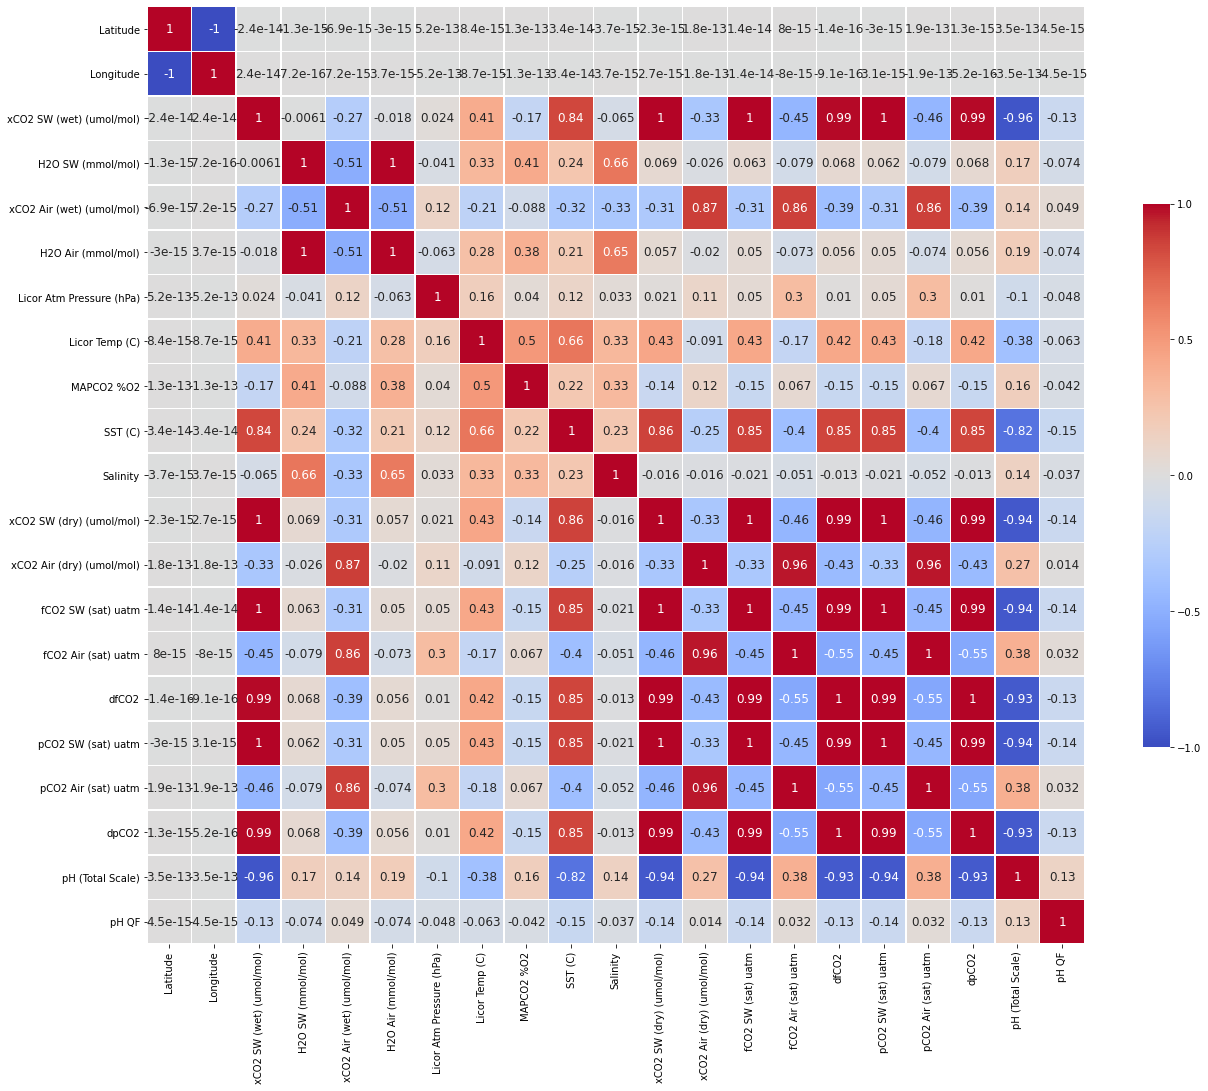

In [16]:
# setting figure size
f, ax = plt.subplots(figsize=(21,25)) 
heatmap = sns.heatmap(corr_matrix,
                      square = True,
                      linewidths = .5,
                      cmap = "coolwarm", # choosing color type for graph
                      cbar_kws = {"shrink": .4, 
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [116]:
chuuk_df = chuuk.copy()
chuuk_df

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),H2O SW (mmol/mol),xCO2 Air (wet) (umol/mol),H2O Air (mmol/mol),Licor Atm Pressure (hPa),Licor Temp (C),MAPCO2 %O2,SST (C),...,xCO2 SW (dry) (umol/mol),xCO2 Air (dry) (umol/mol),fCO2 SW (sat) uatm,fCO2 Air (sat) uatm,dfCO2,pCO2 SW (sat) uatm,pCO2 Air (sat) uatm,dpCO2,pH (Total Scale),pH QF
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-04-24,7.464,151.898,397.9250,9.56000,394.3750,8.70500,1006.9750,30.6750,99.67750,28.855500,...,401.7750,397.8750,382.6750,378.9500,3.7000,383.8250,380.1000,3.7250,8.033000,2.0
2013-04-25,7.464,151.898,396.5750,10.11625,393.7750,9.10875,1006.8125,30.9125,99.57625,28.933125,...,400.6250,397.4000,381.4250,378.3875,3.0500,382.5875,379.5250,3.0625,8.040000,2.0
2013-04-26,7.464,151.898,398.0875,10.34625,393.6000,9.18375,1006.7750,31.2625,99.49250,28.989875,...,402.2625,397.2500,382.9375,378.1500,4.7875,384.0875,379.3000,4.8000,8.034750,2.0
2013-04-27,7.464,151.898,399.6750,10.49250,393.6625,9.42500,1006.7125,31.1000,99.44250,28.981000,...,403.9000,397.4000,384.5125,378.3125,6.2000,385.6500,379.4500,6.2125,8.035625,2.0
2013-04-28,7.464,151.898,395.5625,10.24000,393.0375,9.39875,1007.1500,30.6375,99.57750,28.957750,...,399.6500,396.7625,380.6250,377.8625,2.7375,381.7625,379.0250,2.7625,8.040250,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-04,7.464,151.898,437.6375,4.93750,389.7375,3.80625,1008.1000,33.1125,99.15875,30.236125,...,439.8375,391.2250,418.0000,371.8125,46.1875,419.2625,372.9250,46.3375,7.987250,2.0
2014-08-05,7.464,151.898,435.6250,5.13125,391.2875,3.98875,1007.7000,32.1500,99.17625,30.186875,...,437.8625,392.8375,416.0250,373.2625,42.7625,417.2625,374.3875,42.8875,7.984375,2.0
2014-08-08,7.464,151.898,415.6625,4.00250,390.9625,3.29500,1008.0250,30.1875,99.24625,29.501750,...,417.3250,392.2625,397.3125,373.4250,23.8875,398.5125,374.5750,23.9625,8.005000,2.0


In [18]:
# Dropping all features that did not have significant correlation with target, pH
chuuk_df = chuuk_df.drop(["H2O SW (mmol/mol)", "xCO2 Air (wet) (umol/mol)", "H2O Air (mmol/mol)", 
                    "Licor Temp (C)", "MAPCO2 %O2", "Salinity", "xCO2 Air (dry) (umol/mol)", "fCO2 Air (sat) uatm",
                    "pCO2 Air (sat) uatm", "pH QF"],
                   axis = 1)
chuuk_df.head(3)

,Latitude,Longitude,xCO2 SW (wet) (umol/mol),Licor Atm Pressure (hPa),SST (C),xCO2 SW (dry) (umol/mol),fCO2 SW (sat) uatm,dfCO2,pCO2 SW (sat) uatm,dpCO2,pH (Total Scale)
Datetime,,,,,,,,,,,
2013-04-24,7.464,151.898,397.9250,1006.9750,28.855500,401.7750,382.6750,3.7000,383.8250,3.7250,8.03300
2013-04-25,7.464,151.898,396.5750,1006.8125,28.933125,400.6250,381.4250,3.0500,382.5875,3.0625,8.04000
2013-04-26,7.464,151.898,398.0875,1006.7750,28.989875,402.2625,382.9375,4.7875,384.0875,4.8000,8.03475


In [24]:
chuuk_df = chuuk_df.drop(["Latitude", "Longitude"], axis = 1)

In [19]:
# creating easier reference for features
xCO2w = chuuk_df["xCO2 SW (wet) (umol/mol)"]
AtmP = chuuk_df["Licor Atm Pressure (hPa)"]
SST = chuuk_df["SST (C)"]
xCO2d = chuuk_df["xCO2 SW (dry) (umol/mol)"]
fCO2 = chuuk_df["fCO2 SW (sat) uatm"]
dfCO2 = chuuk_df["dfCO2"]
pCO2 = chuuk_df["pCO2 SW (sat) uatm"]
dpCO2 = chuuk_df["dpCO2"]
pH = chuuk_df["pH (Total Scale)"]

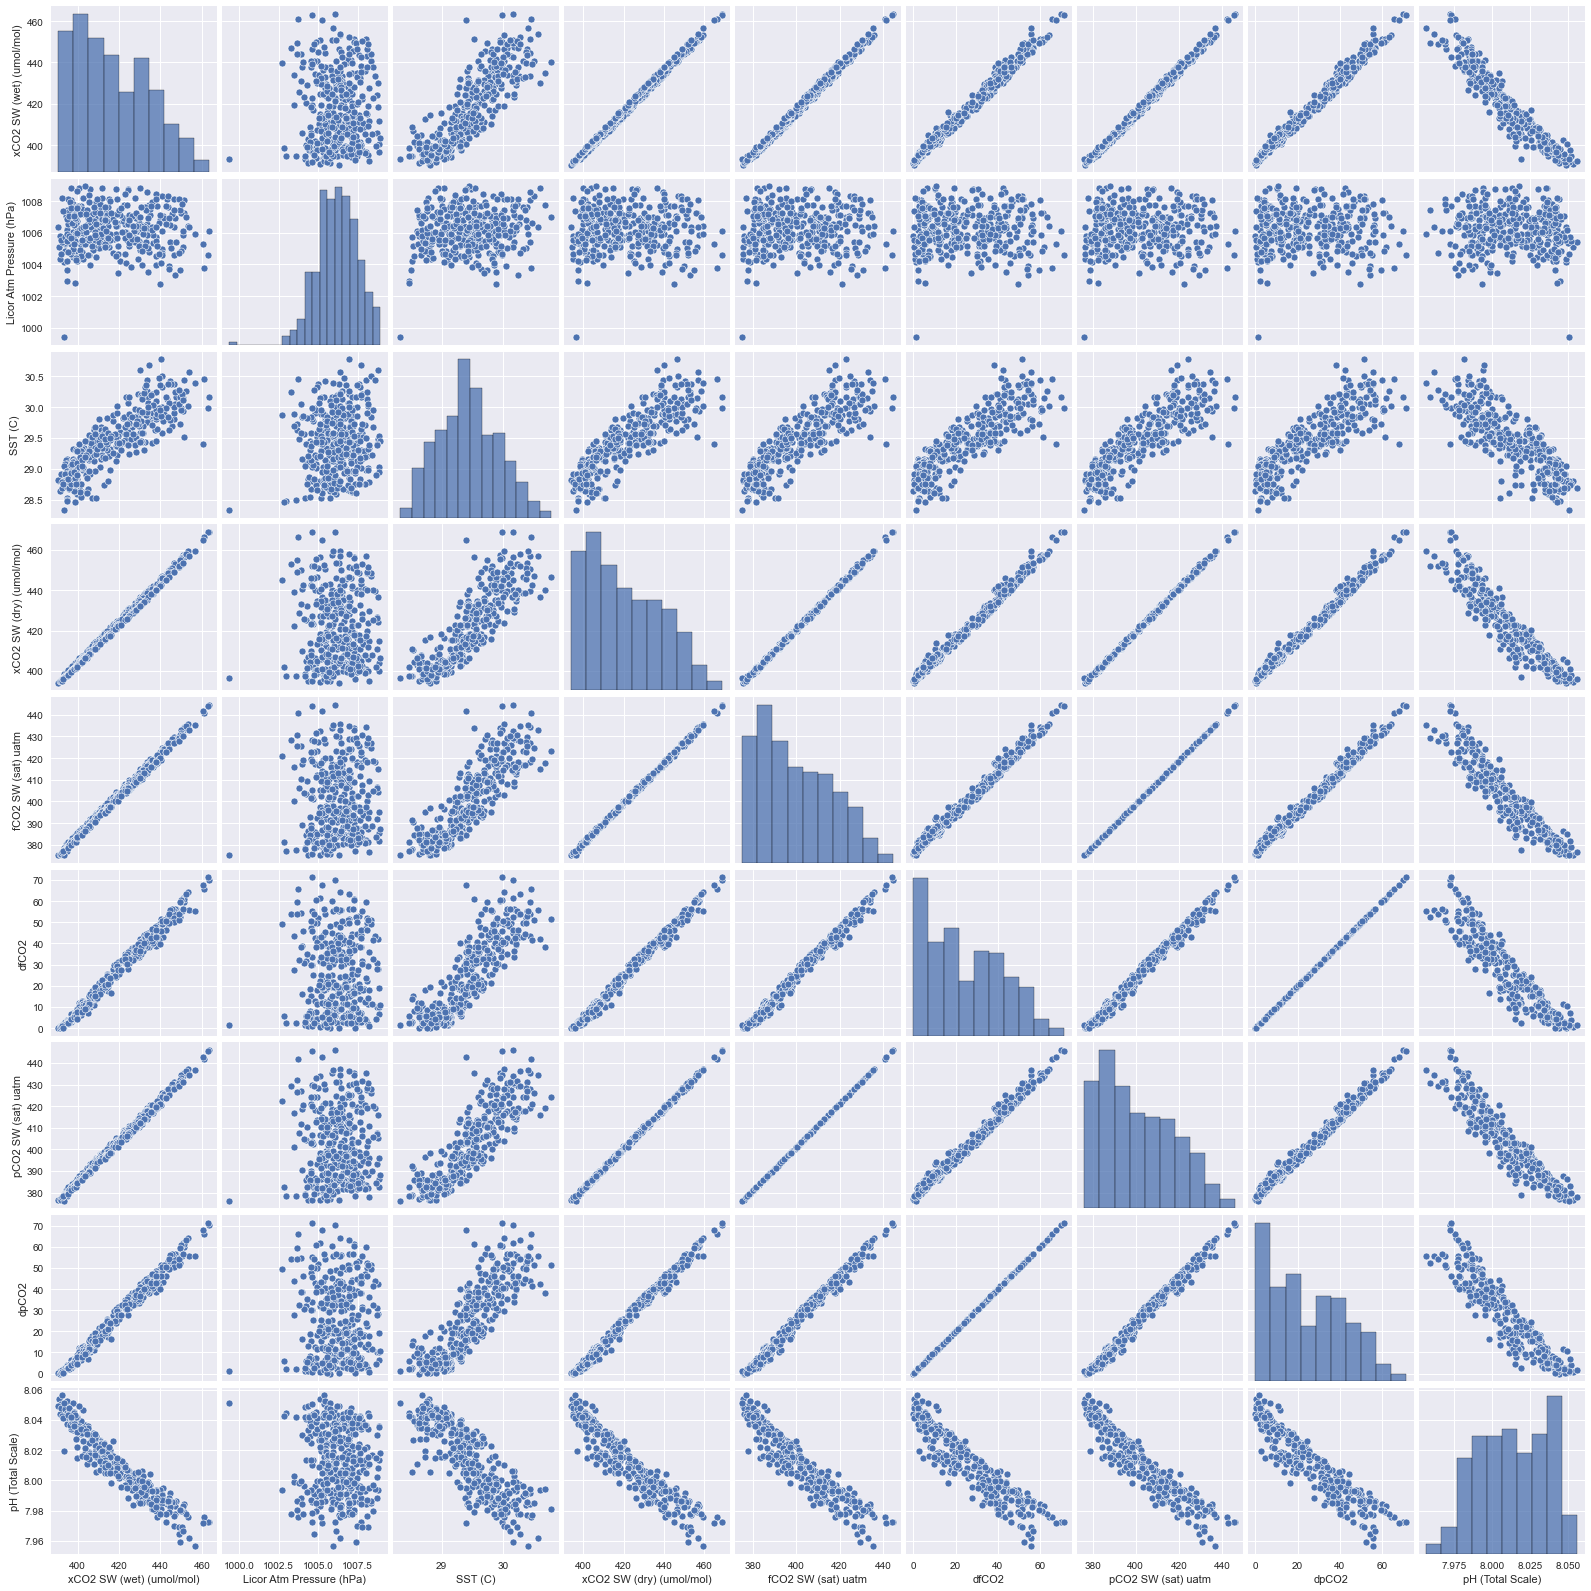

In [25]:
# Pairplot to see correaltions and histograms
sns.pairplot(chuuk_df)

C:\Users\datre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\datre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\datre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\datre\anaconda3\lib\si

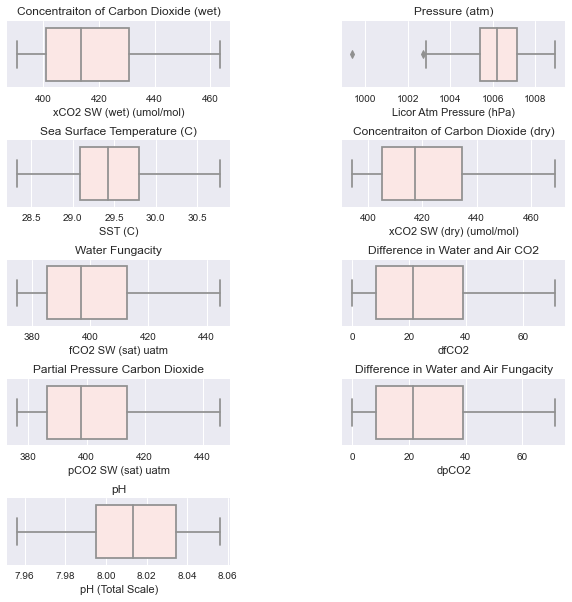

In [26]:
# Subplot for boxplots of each feature
plt.style.use('seaborn')
fig, axis = plt.subplots(nrows = 5, ncols = 2)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace = 0.5, hspace = 0.8)

# plot 1
sns.boxplot(xCO2w, color = 'mistyrose', ax = axis[0,0]).set_title("Concentraiton of Carbon Dioxide (wet)")
# plot 2
sns.boxplot(AtmP, color = 'mistyrose', ax = axis[0,1]).set_title("Pressure (atm)")
# plot 3
sns.boxplot(SST, color = 'mistyrose', ax = axis[1,0]).set_title("Sea Surface Temperature (C)")
# plot 4
sns.boxplot(xCO2d, color = 'mistyrose', ax = axis[1,1]).set_title("Concentraiton of Carbon Dioxide (dry)")
# plot 5
sns.boxplot(fCO2, color = 'mistyrose', ax = axis[2,0]).set_title("Water Fungacity")
# plot 6
sns.boxplot(dfCO2, color = 'mistyrose', ax = axis[2,1]).set_title("Difference in Water and Air CO2")
# plot 7
sns.boxplot(pCO2, color = 'mistyrose', ax = axis[3,0]).set_title("Partial Pressure Carbon Dioxide")
# plot 8
sns.boxplot(dpCO2, color = 'mistyrose', ax = axis[3,1]).set_title("Difference in Water and Air Fungacity")
# plot 9
sns.boxplot(pH, color = 'mistyrose', ax = axis[4,0]).set_title("pH")

ax = axis[4,1].set_visible(False)

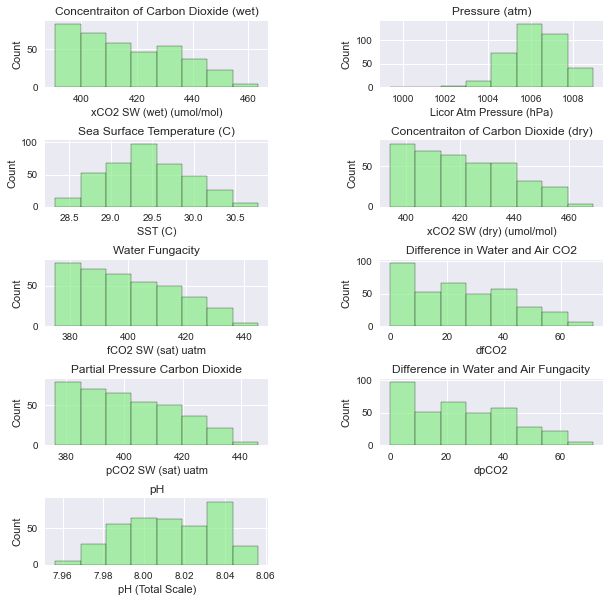

In [27]:
# Subplot for boxplots of each feature
plt.style.use('seaborn')
fig, axis = plt.subplots(nrows = 5, ncols = 2)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace = 0.5, hspace = 0.8)

# plot 1
sns.histplot(xCO2w, color = 'lightgreen', bins = 8, ax = axis[0,0]).set_title("Concentraiton of Carbon Dioxide (wet)")
# plot 2
sns.histplot(AtmP, color = 'lightgreen', bins = 8, ax = axis[0,1]).set_title("Pressure (atm)")
# plot 3
sns.histplot(SST, color = 'lightgreen', bins = 8, ax = axis[1,0]).set_title("Sea Surface Temperature (C)")
# plot 4
sns.histplot(xCO2d, color = 'lightgreen', bins = 8, ax = axis[1,1]).set_title("Concentraiton of Carbon Dioxide (dry)")
# plot 5
sns.histplot(fCO2, color = 'lightgreen', bins = 8, ax = axis[2,0]).set_title("Water Fungacity")
# plot 6
sns.histplot(dfCO2, color = 'lightgreen', bins = 8, ax = axis[2,1]).set_title("Difference in Water and Air CO2")
# plot 7
sns.histplot(pCO2, color = 'lightgreen', bins = 8, ax = axis[3,0]).set_title("Partial Pressure Carbon Dioxide")
# plot 8
sns.histplot(dpCO2, color = 'lightgreen', bins = 8, ax = axis[3,1]).set_title("Difference in Water and Air Fungacity")
# plot 9
sns.histplot(pH, color = 'lightgreen', bins = 8, ax = axis[4,0]).set_title("pH")

ax = axis[4,1].set_visible(False)

IndexError: index 9 is out of bounds for axis 0 with size 9

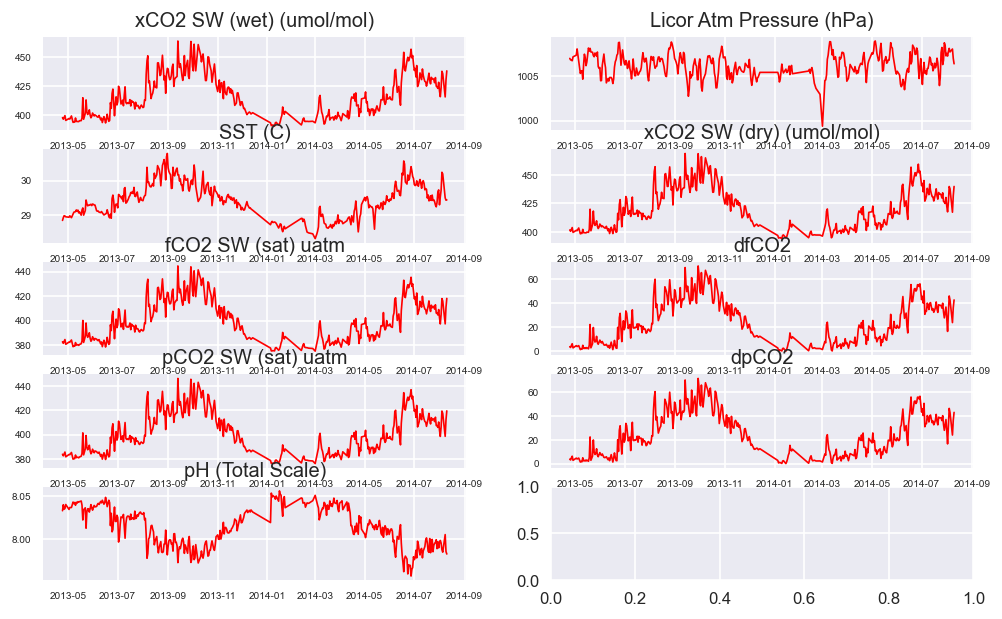

In [28]:
# looking at trends of all data
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6), )
for i, ax in enumerate(axes.flatten()):
    data = chuuk_df[chuuk_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(chuuk_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
subplots.adjust(wspace=4, hspace=20)
plt.show();

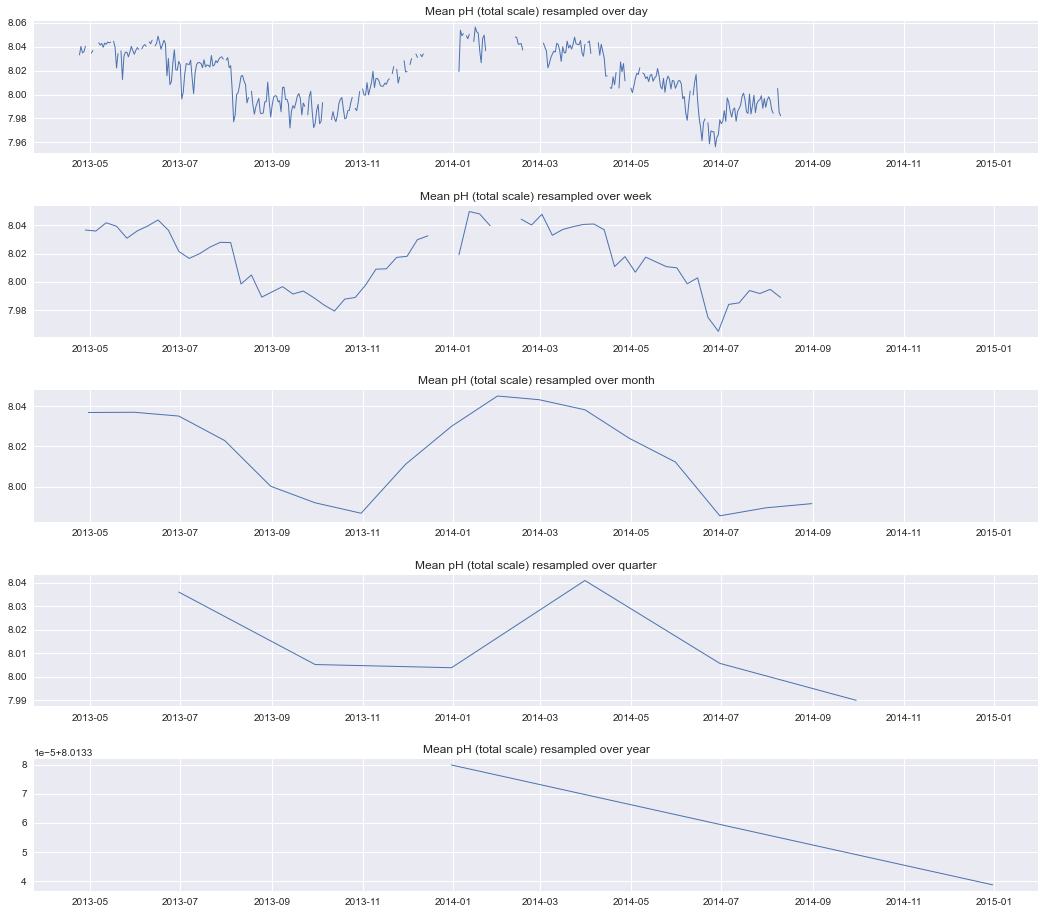

In [29]:
# setting subplots to look at different ways pH can be grouped
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
# Danily average
ax1 = fig.add_subplot(5,1,1)
ax1.plot(chuuk_df['pH (Total Scale)'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean pH (total scale) resampled over day')
ax1.tick_params(axis='both', which='major')
# Weekly Average
ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(chuuk_df['pH (Total Scale)'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean pH (total scale) resampled over week')
ax2.tick_params(axis='both', which='major')
# Monthly Average
ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(chuuk_df['pH (Total Scale)'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean pH (total scale) resampled over month')
ax3.tick_params(axis='both', which='major')
# Quarterly Average
ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(chuuk_df['pH (Total Scale)'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean pH (total scale) resampled over quarter')
ax4.tick_params(axis='both', which='major')
# Yearly Average
ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(chuuk_df['pH (Total Scale)'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean pH (total scale) resampled over year')
ax5.tick_params(axis='both', which='major');

In [26]:
chuuk_df.index = pd.DatetimeIndex(chuuk_df.index).to_period("D")
chuuk_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 379 entries, 2013-04-24 to 2014-08-10
Freq: D
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   xCO2 SW (wet) (umol/mol)  379 non-null    float64
 1   Licor Atm Pressure (hPa)  379 non-null    float64
 2   SST (C)                   379 non-null    float64
 3   xCO2 SW (dry) (umol/mol)  379 non-null    float64
 4   fCO2 SW (sat) uatm        379 non-null    float64
 5   dfCO2                     379 non-null    float64
 6   pCO2 SW (sat) uatm        379 non-null    float64
 7   dpCO2                     379 non-null    float64
 8   pH (Total Scale)          379 non-null    float64
dtypes: float64(9)
memory usage: 29.6 KB


In [30]:
# Splitting test and train set
train = chuuk_df[:int(0.8*(len(chuuk_df)))]
valid = chuuk_df[int(0.8*(len(chuuk_df))):]
print(train.shape)
print(valid.shape)

(303, 9)
(76, 9)


In [31]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(chuuk_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
xCO2 SW (wet) (umol/mol) ::  285.21    > 179.5199  =>   True
Licor Atm Pressure (hPa) ::  202.63    > 143.6691  =>   True
SST (C) ::  131.67    > 111.7797  =>   True
xCO2 SW (dry) (umol/mol) ::  81.44     > 83.9383   =>   False
fCO2 SW (sat) uatm ::  47.12     > 60.0627   =>   False
dfCO2  ::  23.24     > 40.1749   =>   False
pCO2 SW (sat) uatm ::  9.84      > 24.2761   =>   False
dpCO2  ::  3.21      > 12.3212   =>   False
pH (Total Scale) ::  0.16      > 4.1296    =>   False


In [32]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [33]:
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "xCO2 SW (wet) (umol/mol)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4415
 No. Lags Chosen       = 10
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.5622. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Licor Atm Pressure (hPa)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1375
 No. Lags Chosen       = 3
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SST (C)" 
    -----------------------------------------------
 Null Hypothesi

In [34]:
# 1st difference
train_diff = train.diff().dropna()

In [35]:
# ADF Test on each column
for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "xCO2 SW (wet) (umol/mol)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.012
 No. Lags Chosen       = 9
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Licor Atm Pressure (hPa)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3988
 No. Lags Chosen       = 13
 Critical value 1%     = -3.453
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SST (C)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

In [36]:
model = VAR(train_diff)
x = model.select_order(maxlags=10)
x.summary()

C:\Users\datre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


,AIC,BIC,FPE,HQIC
0,-34.86,-34.75*,7.230e-16,-34.82
1,-35.81,-34.67,2.814e-16,-35.35
2,-36.28,-34.13,1.753e-16,-35.42*
3,-36.64*,-33.46,1.234e-16*,-35.37
4,-36.62,-32.43,1.263e-16,-34.94
5,-36.55,-31.34,1.370e-16,-34.46
6,-36.59,-30.36,1.333e-16,-34.10
7,-36.52,-29.26,1.475e-16,-33.61
8,-36.44,-28.17,1.646e-16,-33.13
9,-36.45,-27.16,1.698e-16,-32.73


In [37]:
# Using fit 3 from results above
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Jun, 2021
Time:                     16:51:17
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -33.6672
Nobs:                     299.000    HQIC:                  -35.5377
Log likelihood:           1933.14    FPE:                1.06221e-16
AIC:                     -36.7860    Det(Omega_mle):     4.74593e-17
--------------------------------------------------------------------
Results for equation xCO2 SW (wet) (umol/mol)
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.092659         0.370431            0.250           0.802
L1.xCO2 SW (wet) (umol/mol)        -1.697108         1.572509           -1.079  

In [38]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(chuuk_df.columns, out):
    print(col, ':', round(val, 2))

xCO2 SW (wet) (umol/mol) : 1.97
Licor Atm Pressure (hPa) : 2.0
SST (C) : 2.05
xCO2 SW (dry) (umol/mol) : 1.97
fCO2 SW (sat) uatm : 1.98
dfCO2 : 1.99
pCO2 SW (sat) uatm : 1.98
dpCO2 : 1.99
pH (Total Scale) : 1.98


In [39]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]
forecast_input

3


array([[ 5.11250e+00,  8.75000e-02,  4.53750e-02,  5.13750e+00,
         4.87500e+00,  5.27500e+00,  4.88750e+00,  5.31250e+00,
        -6.00000e-03],
       [ 4.52500e+00,  3.12500e-01,  1.25125e-01,  4.73750e+00,
         4.52500e+00,  5.32500e+00,  4.51250e+00,  5.33750e+00,
        -8.87500e-03],
       [-7.50000e-02, -6.25000e-02, -1.50000e-02, -1.87500e-01,
        -2.00000e-01, -3.50000e-01, -2.00000e-01, -3.25000e-01,
        -2.25000e-03]])

In [40]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps = len(train_diff))
df_forecast = pd.DataFrame(fc, index=train_diff.index, columns = chuuk_df.columns + "_1d")
df_forecast

,xCO2 SW (wet) (umol/mol)_1d,Licor Atm Pressure (hPa)_1d,SST (C)_1d,xCO2 SW (dry) (umol/mol)_1d,fCO2 SW (sat) uatm_1d,dfCO2_1d,pCO2 SW (sat) uatm_1d,dpCO2_1d,pH (Total Scale)_1d
Datetime,,,,,,,,,
2013-04-25,-3.011511,-0.113039,-0.032469,-3.052355,-2.919747,-3.185919,-2.920522,-3.220280,0.005145
2013-04-26,1.503981,-0.063022,0.016578,1.531379,1.411335,1.539328,1.414204,1.548054,-0.002005
2013-04-27,1.754687,-0.029876,0.007649,1.746079,1.636270,1.805490,1.640750,1.812185,-0.002062
2013-04-28,-1.666134,-0.044382,-0.027470,-1.692304,-1.589906,-1.692350,-1.597855,-1.692765,0.002181
2013-05-02,-0.337657,0.052205,0.000268,-0.351231,-0.312635,-0.333211,-0.310113,-0.339033,0.000169
...,...,...,...,...,...,...,...,...,...
2014-05-18,0.043320,-0.001188,0.001062,0.038493,0.035133,0.041571,0.035227,0.041692,-0.000092
2014-05-19,0.043320,-0.001188,0.001062,0.038493,0.035133,0.041571,0.035227,0.041692,-0.000092
2014-05-20,0.043320,-0.001188,0.001062,0.038493,0.035133,0.041571,0.035227,0.041692,-0.000092


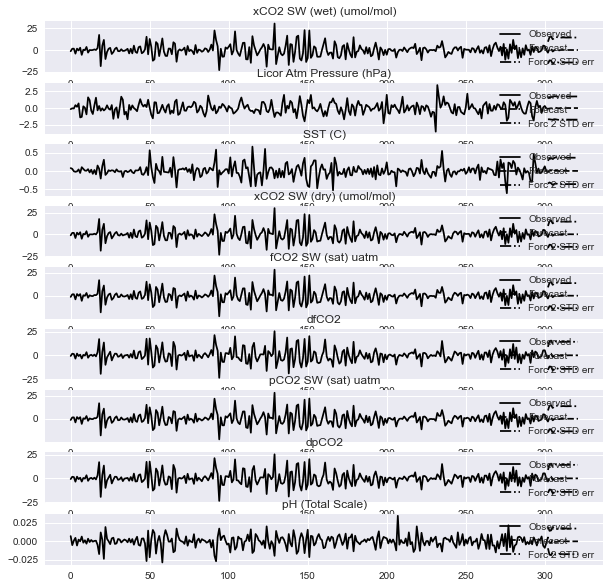

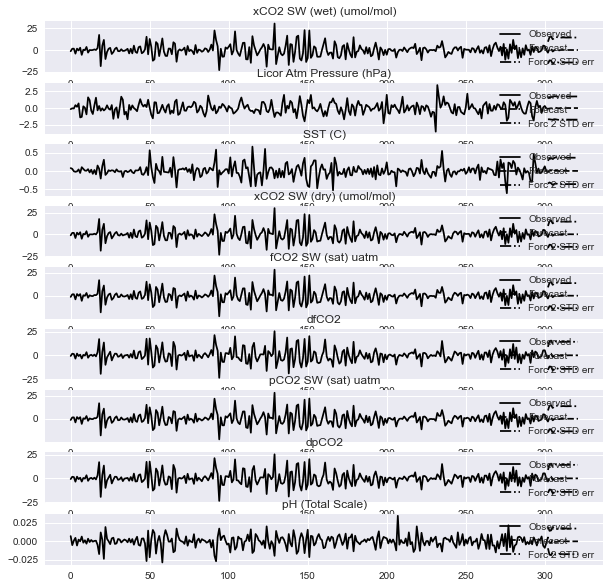

In [41]:
model_fitted.plot_forecast(20)

In [42]:
fevd = model_fitted.fevd(5)
fevd.summary()

FEVD for xCO2 SW (wet) (umol/mol)
     xCO2 SW (wet) (umol/mol)  Licor Atm Pressure (hPa)   SST (C)  xCO2 SW (dry) (umol/mol)  fCO2 SW (sat) uatm     dfCO2  pCO2 SW (sat) uatm     dpCO2  pH (Total Scale)
0                    1.000000                  0.000000  0.000000                  0.000000            0.000000  0.000000            0.000000  0.000000          0.000000
1                    0.927590                  0.000072  0.002589                  0.000009            0.001887  0.060801            0.001849  0.004411          0.000791
2                    0.902973                  0.001953  0.011743                  0.000025            0.005128  0.060891            0.011055  0.005438          0.000794
3                    0.872782                  0.005558  0.013027                  0.000025            0.007405  0.069973            0.017816  0.012222          0.001192
4                    0.865162                  0.005593  0.012950                  0.000845            0.007709  0.0

In [43]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[col] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [45]:
# Creating result dataframe
df_results = invert_transformation(train, df_forecast, second_diff=False)
df_results["Type"] = "Forecast"
df_results.head(2)

,xCO2 SW (wet) (umol/mol)_1d,Licor Atm Pressure (hPa)_1d,SST (C)_1d,xCO2 SW (dry) (umol/mol)_1d,fCO2 SW (sat) uatm_1d,dfCO2_1d,pCO2 SW (sat) uatm_1d,dpCO2_1d,pH (Total Scale)_1d,xCO2 SW (wet) (umol/mol),Licor Atm Pressure (hPa),SST (C),xCO2 SW (dry) (umol/mol),fCO2 SW (sat) uatm,dfCO2,pCO2 SW (sat) uatm,dpCO2,pH (Total Scale),Type
Datetime,,,,,,,,,,,,,,,,,,,
2013-04-25,-3.011511,-0.113039,-0.032469,-3.052355,-2.919747,-3.185919,-2.920522,-3.220280,0.005145,410.188489,1006.661961,29.310906,412.885145,392.705253,16.126581,393.879478,16.167220,8.009645,Forecast
2013-04-26,1.503981,-0.063022,0.016578,1.531379,1.411335,1.539328,1.414204,1.548054,-0.002005,411.692470,1006.598939,29.327484,414.416524,394.116588,17.665909,395.293681,17.715274,8.007640,Forecast


In [46]:
# Dropping all features that did not have significant correlation with target, pH
df_results = df_results.drop(["xCO2 SW (wet) (umol/mol)_1d", "Licor Atm Pressure (hPa)_1d", "SST (C)_1d", "xCO2 SW (dry) (umol/mol)_1d", "fCO2 SW (sat) uatm_1d", "dfCO2_1d", "pCO2 SW (sat) uatm_1d", "dpCO2_1d", "pH (Total Scale)_1d", "Type"],
                   axis = 1)
df_results["Type"] = "Forecast"
df_results.head(3)

,xCO2 SW (wet) (umol/mol),Licor Atm Pressure (hPa),SST (C),xCO2 SW (dry) (umol/mol),fCO2 SW (sat) uatm,dfCO2,pCO2 SW (sat) uatm,dpCO2,pH (Total Scale),Type
Datetime,,,,,,,,,,
2013-04-25,410.188489,1006.661961,29.310906,412.885145,392.705253,16.126581,393.879478,16.167220,8.009645,Forecast
2013-04-26,411.692470,1006.598939,29.327484,414.416524,394.116588,17.665909,395.293681,17.715274,8.007640,Forecast
2013-04-27,413.447156,1006.569063,29.335133,416.162603,395.752858,19.471398,396.934431,19.527458,8.005578,Forecast


In [47]:
df_results.index

DatetimeIndex(['2013-04-25', '2013-04-26', '2013-04-27', '2013-04-28',
               '2013-05-02', '2013-05-03', '2013-05-05', '2013-05-07',
               '2013-05-08', '2013-05-09',
               ...
               '2014-05-13', '2014-05-14', '2014-05-15', '2014-05-16',
               '2014-05-17', '2014-05-18', '2014-05-19', '2014-05-20',
               '2014-05-21', '2014-05-22'],
              dtype='datetime64[ns]', name='Datetime', length=302, freq=None)

In [44]:
df_results.index = df_results.index.to_timestamp()

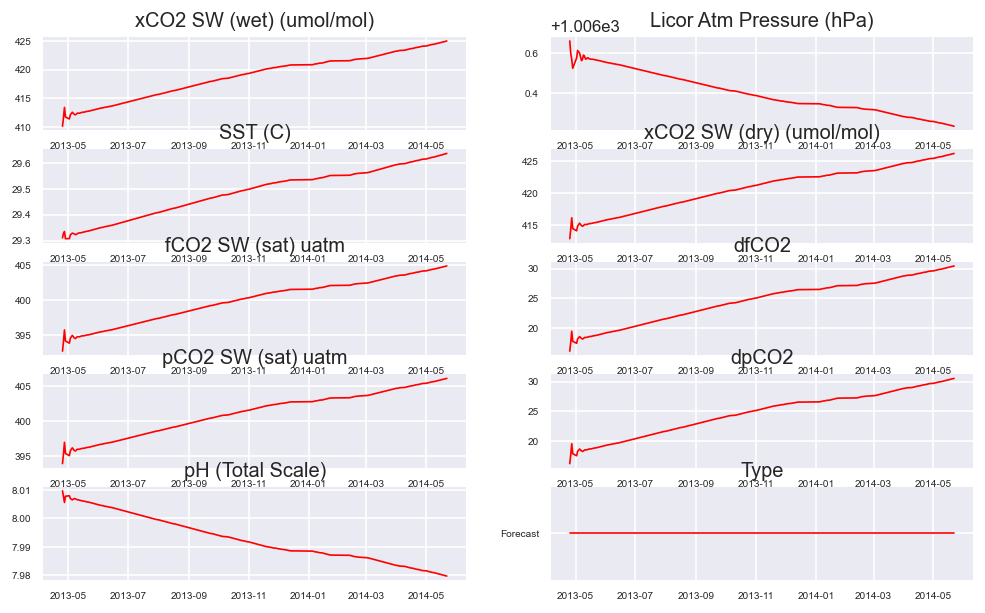

In [48]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6), )
for i, ax in enumerate(axes.flatten()):
    data = df_results[df_results.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_results.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.show();

In [49]:
df_actual = pd.DataFrame(chuuk_df, index = df_results.index, columns = chuuk_df.columns)
df_actual["Type"] = "Actual"
df_actual

,xCO2 SW (wet) (umol/mol),Licor Atm Pressure (hPa),SST (C),xCO2 SW (dry) (umol/mol),fCO2 SW (sat) uatm,dfCO2,pCO2 SW (sat) uatm,dpCO2,pH (Total Scale),Type
Datetime,,,,,,,,,,
2013-04-25,396.5750,1006.8125,28.933125,400.6250,381.4250,3.0500,382.5875,3.0625,8.040000,Actual
2013-04-26,398.0875,1006.7750,28.989875,402.2625,382.9375,4.7875,384.0875,4.8000,8.034750,Actual
2013-04-27,399.6750,1006.7125,28.981000,403.9000,384.5125,6.2000,385.6500,6.2125,8.035625,Actual
2013-04-28,395.5625,1007.1500,28.957750,399.6500,380.6250,2.7375,381.7625,2.7625,8.040250,Actual
2013-05-02,397.1625,1007.3375,28.946375,401.4875,382.4500,4.6000,383.6250,4.6125,8.034500,Actual
...,...,...,...,...,...,...,...,...,...,...
2014-05-18,403.8875,1007.1750,29.228875,406.6750,387.0750,9.7500,388.2625,9.7875,8.015125,Actual
2014-05-19,403.6375,1006.4375,29.187875,406.2500,386.4250,9.0625,387.6000,9.0625,8.021625,Actual
2014-05-20,408.7500,1006.5250,29.233250,411.3875,391.3000,14.3375,392.4875,14.3750,8.015625,Actual


In [50]:
# combining dataframes for better visual
dfs = [df_actual, df_results]
df_vis = df_actual.append(df_results)
df_vis

,xCO2 SW (wet) (umol/mol),Licor Atm Pressure (hPa),SST (C),xCO2 SW (dry) (umol/mol),fCO2 SW (sat) uatm,dfCO2,pCO2 SW (sat) uatm,dpCO2,pH (Total Scale),Type
Datetime,,,,,,,,,,
2013-04-25,396.575000,1006.812500,28.933125,400.625000,381.425000,3.050000,382.587500,3.062500,8.040000,Actual
2013-04-26,398.087500,1006.775000,28.989875,402.262500,382.937500,4.787500,384.087500,4.800000,8.034750,Actual
2013-04-27,399.675000,1006.712500,28.981000,403.900000,384.512500,6.200000,385.650000,6.212500,8.035625,Actual
2013-04-28,395.562500,1007.150000,28.957750,399.650000,380.625000,2.737500,381.762500,2.762500,8.040250,Actual
2013-05-02,397.162500,1007.337500,28.946375,401.487500,382.450000,4.600000,383.625000,4.612500,8.034500,Actual
...,...,...,...,...,...,...,...,...,...,...
2014-05-18,424.805184,1006.237609,29.631702,426.087817,404.788438,30.292703,405.993113,30.381310,7.980094,Forecast
2014-05-19,424.848504,1006.236421,29.632764,426.126310,404.823572,30.334274,406.028341,30.423002,7.980002,Forecast
2014-05-20,424.891824,1006.235234,29.633827,426.164803,404.858705,30.375845,406.063568,30.464694,7.979910,Forecast


In [51]:
type(df_vis.index)

pandas.core.indexes.datetimes.DatetimeIndex

C:\Users\datre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\datre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\datre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\datre\anacond

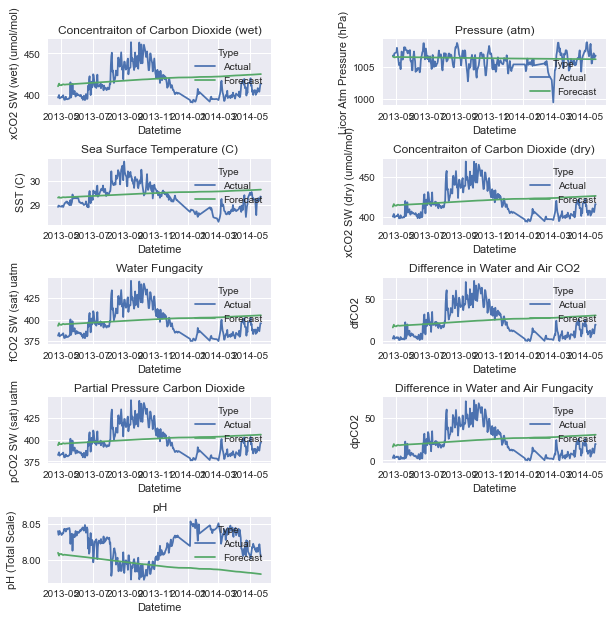

In [52]:
plt.style.use('seaborn')
fig, axis = plt.subplots(nrows = 5, ncols = 2)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace = 0.5, hspace = 0.8)

# plot 1
sns.lineplot(df_vis.index, df_vis["xCO2 SW (wet) (umol/mol)"], hue = df_vis["Type"], ax = axis[0,0]).set_title("Concentraiton of Carbon Dioxide (wet)")
# plot 2
sns.lineplot(df_vis.index, df_vis["Licor Atm Pressure (hPa)"], hue = df_vis["Type"], ax = axis[0,1]).set_title("Pressure (atm)")
# plot 3
sns.lineplot(df_vis.index, df_vis["SST (C)"], hue = df_vis["Type"], ax = axis[1,0]).set_title("Sea Surface Temperature (C)")
# plot 4
sns.lineplot(df_vis.index, df_vis["xCO2 SW (dry) (umol/mol)"], hue = df_vis["Type"], ax = axis[1,1]).set_title("Concentraiton of Carbon Dioxide (dry)")
# plot 5
sns.lineplot(df_vis.index, df_vis["fCO2 SW (sat) uatm"], hue = df_vis["Type"], ax = axis[2,0]).set_title("Water Fungacity")
# plot 6
sns.lineplot(df_vis.index, df_vis["dfCO2"], hue = df_vis["Type"], ax = axis[2,1]).set_title("Difference in Water and Air CO2")
# plot 7
sns.lineplot(df_vis.index, df_vis["pCO2 SW (sat) uatm"], hue = df_vis["Type"], ax = axis[3,0]).set_title("Partial Pressure Carbon Dioxide")
# plot 8
sns.lineplot(df_vis.index, df_vis["dpCO2"], hue = df_vis["Type"], ax = axis[3,1]).set_title("Difference in Water and Air Fungacity")
# plot 9
sns.lineplot(df_vis.index, df_vis["pH (Total Scale)"], hue = df_vis["Type"], ax = axis[4,0]).set_title("pH")

ax = axis[4,1].set_visible(False)

<AxesSubplot:xlabel='Datetime', ylabel='pH (Total Scale)'>

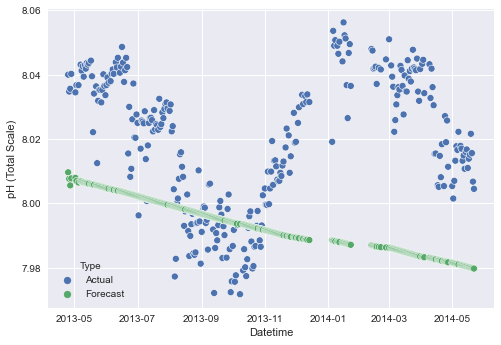

In [53]:
# Isolating pH results
sns.scatterplot(x = df_vis.index, y = df_vis["pH (Total Scale)"], hue = df_vis.Type)

In [54]:
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from keras.models import load_model
from sklearn.metrics import r2_score
import plotly.graph_objects as go

In [55]:
def create_dataset(dataset, lookback=1):
    dataX = []
    dataY = []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        dataY.append(dataset[i+lookback,0])
    return np.array(dataX), np.array(dataY)

In [56]:
# input data
data = chuuk_df["pH (Total Scale)"].values
data = data.astype("float32")

In [57]:
# correcting shape of data
scaler = MinMaxScaler(feature_range=(0,1))
data = data.reshape(-1,1)
data = scaler.fit_transform(data)

In [58]:
# Splitting into test and train sets
train = data[:int(len(data)*0.8), :]
test = data[int(len(data)*0.8):, :]

In [59]:
lookback = 1
trainX, trainY = create_dataset(train, lookback)
testX, testY = create_dataset(test, lookback)

In [60]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [61]:
model = Sequential()
# Check LSTM
model.add(LSTM(4, input_shape=(1, lookback)))
#return_sequences=True, model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
301/301 - 5s - loss: 0.1952 - mae: 0.3815
Epoch 2/100
301/301 - 1s - loss: 0.0227 - mae: 0.1272
Epoch 3/100
301/301 - 1s - loss: 0.0180 - mae: 0.1118
Epoch 4/100
301/301 - 1s - loss: 0.0156 - mae: 0.1039
Epoch 5/100
301/301 - 1s - loss: 0.0135 - mae: 0.0952
Epoch 6/100
301/301 - 1s - loss: 0.0116 - mae: 0.0867
Epoch 7/100
301/301 - 1s - loss: 0.0099 - mae: 0.0780
Epoch 8/100
301/301 - 1s - loss: 0.0087 - mae: 0.0723
Epoch 9/100
301/301 - 1s - loss: 0.0079 - mae: 0.0674
Epoch 10/100
301/301 - 1s - loss: 0.0073 - mae: 0.0625
Epoch 11/100
301/301 - 1s - loss: 0.0071 - mae: 0.0621
Epoch 12/100
301/301 - 1s - loss: 0.0071 - mae: 0.0617
Epoch 13/100
301/301 - 1s - loss: 0.0070 - mae: 0.0610
Epoch 14/100
301/301 - 1s - loss: 0.0070 - mae: 0.0612
Epoch 15/100
301/301 - 1s - loss: 0.0069 - mae: 0.0608
Epoch 16/100
301/301 - 1s - loss: 0.0069 - mae: 0.0608
Epoch 17/100
301/301 - 1s - loss: 0.0069 - mae: 0.0606
Epoch 18/100
301/301 - 1s - loss: 0.0069 - mae: 0.0608
Epoch 19/100
301/30

In [62]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [63]:
#nsamples, nx, ny = trainY.shape
#trainY = trainY.reshape((nsamples,nx*ny))

In [64]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


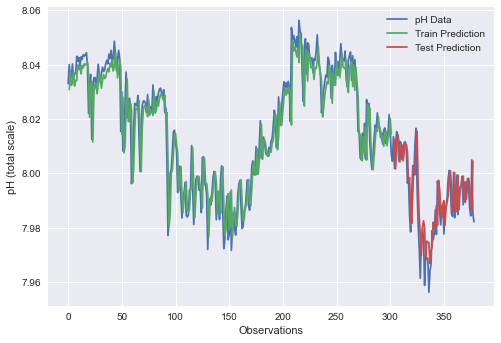

In [65]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data), label="pH Data")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("pH (total scale)")
plt.legend()
plt.show()

In [66]:
model.save("pH_model.h5")

In [67]:
model = load_model("pH_model.h5")

In [68]:
trainScore = math.sqrt(r2_score(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f R2' % (trainScore))
testScore = math.sqrt(r2_score(testY[0], testPredict[:,0]))
print('Test Score: %.2f R2' % (testScore))

Train Score: 0.92 R2
Test Score: 0.77 R2
